# Market Basket Anlysis pada Data Online Retail

## 1. Import libraries dan dataset

In [2]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import datetime as dt
import time
from memory_profiler import memory_usage

# Parameter Konfigurasi Runtime untuk Matplotlib
plt.rcParams['font.family'] = 'Verdana'
plt.style.use('ggplot')

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Apriori Algorithm
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# Fp-growth Algorithm
from mlxtend.frequent_patterns import fpgrowth, association_rules
from mlxtend.preprocessing import TransactionEncoder

In [3]:
# Read data
df = pd.read_csv('CleanOnlineRetail.csv', encoding = 'unicode_escape')
df.head()

C:\Users\USER\AppData\Local\Temp\ipykernel_31820\956812423.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('CleanOnlineRetail.csv', encoding = 'unicode_escape')


,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,Time,Hour,Time of Day,Month,Week of the Year,Day of Week,Sales Revenue
0,0,539993,22386,JUMBO BAG PINK POLKADOT,10,2011-01-04 10:00:00,1.95,13313,United Kingdom,2011-01-04,10:00:00,10,Morning,January,1,Tuesday,19.5
1,1,539993,21499,BLUE POLKADOT WRAP,25,2011-01-04 10:00:00,0.42,13313,United Kingdom,2011-01-04,10:00:00,10,Morning,January,1,Tuesday,10.5
2,2,539993,21498,RED RETROSPOT WRAP,25,2011-01-04 10:00:00,0.42,13313,United Kingdom,2011-01-04,10:00:00,10,Morning,January,1,Tuesday,10.5
3,3,539993,22379,RECYCLING BAG RETROSPOT,5,2011-01-04 10:00:00,2.10,13313,United Kingdom,2011-01-04,10:00:00,10,Morning,January,1,Tuesday,10.5
4,4,539993,20718,RED RETROSPOT SHOPPER BAG,10,2011-01-04 10:00:00,1.25,13313,United Kingdom,2011-01-04,10:00:00,10,Morning,January,1,Tuesday,12.5


In [4]:
# List of all countries
country_list = list(dict(df['Country'].value_counts()).keys())
print('List of all countries:', country_list)

List of all countries: ['United Kingdom', 'Germany', 'France', 'EIRE', 'Spain', 'Netherlands', 'Switzerland', 'Belgium', 'Portugal', 'Australia', 'Norway', 'Channel Islands', 'Italy', 'Finland', 'Cyprus', 'Sweden', 'Austria', 'Denmark', 'Poland', 'Israel', 'Hong Kong', 'Japan', 'Singapore', 'USA', 'Iceland', 'Canada', 'Greece', 'Malta', 'United Arab Emirates', 'European Community', 'RSA', 'Lebanon', 'Brazil', 'Czech Republic', 'Bahrain', 'Saudi Arabia']


In [5]:
# Function yang memfilter data berdasarkan nama negara
def choose_country(country = "all", data = df):
    if country == "all":
        return data
    else:
        temp_df = data[data["Country"] == country]
        temp_df.reset_index(drop= True, inplace= True)
        return temp_df

## 2. United Kingdom data

 Sebagian besar transaksi berasal dari United Kingdom sehingga kami membatasi data yang akan kami gunakan hanya untuk transaksi yang berasal dari United Kingdom

In [6]:
uk_retail = choose_country("United Kingdom")
uk_retail.head()

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,Time,Hour,Time of Day,Month,Week of the Year,Day of Week,Sales Revenue
0,0,539993,22386,JUMBO BAG PINK POLKADOT,10,2011-01-04 10:00:00,1.95,13313,United Kingdom,2011-01-04,10:00:00,10,Morning,January,1,Tuesday,19.5
1,1,539993,21499,BLUE POLKADOT WRAP,25,2011-01-04 10:00:00,0.42,13313,United Kingdom,2011-01-04,10:00:00,10,Morning,January,1,Tuesday,10.5
2,2,539993,21498,RED RETROSPOT WRAP,25,2011-01-04 10:00:00,0.42,13313,United Kingdom,2011-01-04,10:00:00,10,Morning,January,1,Tuesday,10.5
3,3,539993,22379,RECYCLING BAG RETROSPOT,5,2011-01-04 10:00:00,2.10,13313,United Kingdom,2011-01-04,10:00:00,10,Morning,January,1,Tuesday,10.5
4,4,539993,20718,RED RETROSPOT SHOPPER BAG,10,2011-01-04 10:00:00,1.25,13313,United Kingdom,2011-01-04,10:00:00,10,Morning,January,1,Tuesday,12.5


### 2.1 Membuat data basket (keranjang)

- Kami sekarang membuat data basket (keranjang) yang akan berisi kuantitas setiap item yang dibeli per transaksi (InvoiceNo)
- Kerangka data ini pada dasarnya adalah 'keranjang' yang 'dibawa' oleh pelanggan ke kasir di toko
- Ini menunjukkan kepada kita berapa banyak pelanggan/transaksi ini (InvoiceNo) membeli barang tertentu
- Jika angkanya 0, maka pelanggan ini tidak membeli barang tersebut
- Jika menunjukkan nilai lain (misalnya 12), berarti pelanggan telah membeli sebanyak 12 item.

In [7]:
basket_uk = uk_retail.groupby(['InvoiceNo', 'Description']).sum()['Quantity'].unstack().reset_index().fillna(0).set_index('InvoiceNo')
basket_uk.head()

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
539993,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
540001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
540002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
540003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
540004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 2.2 Encode data

- Dalam market basket analysis, jumlah setiap barang yang dibeli tidak terlalu penting
- Yang penting suatu barang dibeli atau tidak, karena kita hanya ingin tahu, apa hubungannya membeli suatu barang dengan membeli barang lainnya.
- Jadi kita mengkodekan data keranjang menjadi data biner yang menunjukkan apakah suatu barang dibeli (1) atau tidak (0)

In [8]:
# Encode
def encoder(x):
    if(x <= 0): return 0
    if(x >= 1): return 1

In [9]:
# Apply to the dataframe
basket_uk_encoded = basket_uk.applymap(encoder)
basket_uk_encoded.head()

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
539993,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
540001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
540002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
540003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
540004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 2.3 Filter transaksi yang lebih dari 1 item

- Dalam market basket analysis, kita akan mengungkap hubungan antara 2 atau lebih item yang dibeli berdasarkan data historis

In [10]:
# Kami akan memfilter transaksi yang kurang dari 2 item
basket_uk_encoded_filtered = basket_uk_encoded[ (basket_uk_encoded > 0).sum(axis=1) >= 2] # Jumlah pengkodean berdasarkan kolom harus >= 2
basket_uk_encoded_filtered.head()

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
539993,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
540001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
540002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
540003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
540005,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 3. Menerapkan algoritma

### 3.1 Apriori Algorithm

- Algoritma Apriori hanya digunakan untuk menemukan item yang sering dibeli dalam dataset
- Dalam menerapkan algoritma apriori, kita dapat menentukan frequent data yang kita inginkan dengan memberikan nilai support
- Disini kita mendefinisikan item yang sering dibeli adalah item yang dibeli sebanyak 2% dari keseluruhan transaksi, artinya saya akan memberikan nilai support sebesar 0,02

In [11]:
# Mengukur waktu untuk algoritma Apriori
start_time_apriori = time.time()

# Menjalankan algoritma Apriori dengan parameter minimum support 0.02
frequent_itemsets = apriori(basket_uk_encoded_filtered, min_support=0.02, use_colnames=True)  # Menemukan itemsets yang sering dengan minimum support 0.02

# Membuat Association Rules
rules_apriori = association_rules(frequent_itemsets, metric="lift", min_threshold=1)  # Menghasilkan aturan asosiasi dengan lift minimal 1

# Urutkan nilai berdasarkan nilai lift
rules_apriori = rules_apriori.sort_values("lift",ascending=False).reset_index(drop= True)

# Menyimpan waktu akhir eksekusi
end_time_apriori = time.time()

# Menghitung total waktu eksekusi algoritma Apriori
apriori_time = end_time_apriori - start_time_apriori

c:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [12]:
rules_apriori

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(WOODEN HEART CHRISTMAS SCANDINAVIAN),(WOODEN STAR CHRISTMAS SCANDINAVIAN),0.031599,0.029497,0.023190,0.733888,24.880265,0.022258,3.646969,0.991126
1,(WOODEN STAR CHRISTMAS SCANDINAVIAN),(WOODEN HEART CHRISTMAS SCANDINAVIAN),0.029497,0.031599,0.023190,0.786192,24.880265,0.022258,4.529292,0.988979
2,(SMALL DOLLY MIX DESIGN ORANGE BOWL),(SMALL MARSHMALLOWS PINK BOWL),0.032519,0.027657,0.021613,0.664646,24.031469,0.020714,2.899456,0.990601
3,(SMALL MARSHMALLOWS PINK BOWL),(SMALL DOLLY MIX DESIGN ORANGE BOWL),0.027657,0.032519,0.021613,0.781473,24.031469,0.020714,4.427278,0.985648
4,"(GREEN REGENCY TEACUP AND SAUCER, ROSES REGENC...",(PINK REGENCY TEACUP AND SAUCER),0.042898,0.045658,0.032190,0.750383,16.435004,0.030232,3.823224,0.981248
...,...,...,...,...,...,...,...,...,...,...
311,(REGENCY CAKESTAND 3 TIER),(PARTY BUNTING),0.099199,0.100775,0.022927,0.231126,2.293479,0.012931,1.169534,0.626088
312,(WHITE HANGING HEART T-LIGHT HOLDER),(PARTY BUNTING),0.126330,0.100775,0.023913,0.189288,1.878315,0.011182,1.109179,0.535223
313,(PARTY BUNTING),(WHITE HANGING HEART T-LIGHT HOLDER),0.100775,0.126330,0.023913,0.237288,1.878315,0.011182,1.145478,0.520012
314,(JUMBO BAG RED RETROSPOT),(WHITE HANGING HEART T-LIGHT HOLDER),0.118841,0.126330,0.026278,0.221117,1.750306,0.011265,1.121695,0.486486


### 3.2 FP-Growth Algorithm

- Algoritma FP-Growth digunakan untuk menemukan item-item yang sering dibeli dalam dataset dengan cara yang lebih efisien dibandingkan algoritma Apriori.
- Dalam menerapkan algoritma FP-Growth, kita juga dapat menentukan frekuensi item yang kita inginkan dengan memberikan nilai dukungannya (support).
- Disini, kita mendefinisikan item yang sering dibeli adalah item yang dibeli sebanyak 2% dari keseluruhan transaksi. Artinya, kita akan memberikan nilai support sebesar 0,02.

In [13]:
# Mengukur waktu untuk algoritma FP-Growth
start_time_fpgrowth = time.time()  # Menyimpan waktu mulai eksekusi

# Menjalankan algoritma FP-Growth dengan parameter minimum support 0.02
frequent_itemsets = fpgrowth(basket_uk_encoded_filtered, min_support=0.02, use_colnames=True)  # Menemukan itemsets yang sering dengan minimum support 0.02

# Membuat Association Rules
rules_fpgrowth = association_rules(frequent_itemsets, metric="lift", min_threshold=1)  # Menghasilkan aturan asosiasi dengan lift minimal 1

# Urutkan nilai berdasarkan nilai lift
rules_fpgrowth = rules_fpgrowth.sort_values("lift",ascending=False).reset_index(drop= True)

# Menyimpan waktu akhir eksekusi
end_time_fpgrowth = time.time()  # Menyimpan waktu akhir eksekusi

# Menghitung total waktu eksekusi algoritma FP-Growth
fpgrowth_time = end_time_fpgrowth - start_time_fpgrowth  # Menghitung total waktu eksekusi algoritma FP-Growth


c:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [14]:
rules_fpgrowth

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(WOODEN STAR CHRISTMAS SCANDINAVIAN),(WOODEN HEART CHRISTMAS SCANDINAVIAN),0.029497,0.031599,0.023190,0.786192,24.880265,0.022258,4.529292,0.988979
1,(WOODEN HEART CHRISTMAS SCANDINAVIAN),(WOODEN STAR CHRISTMAS SCANDINAVIAN),0.031599,0.029497,0.023190,0.733888,24.880265,0.022258,3.646969,0.991126
2,(SMALL MARSHMALLOWS PINK BOWL),(SMALL DOLLY MIX DESIGN ORANGE BOWL),0.027657,0.032519,0.021613,0.781473,24.031469,0.020714,4.427278,0.985648
3,(SMALL DOLLY MIX DESIGN ORANGE BOWL),(SMALL MARSHMALLOWS PINK BOWL),0.032519,0.027657,0.021613,0.664646,24.031469,0.020714,2.899456,0.990601
4,"(GREEN REGENCY TEACUP AND SAUCER, ROSES REGENC...",(PINK REGENCY TEACUP AND SAUCER),0.042898,0.045658,0.032190,0.750383,16.435004,0.030232,3.823224,0.981248
...,...,...,...,...,...,...,...,...,...,...
311,(PARTY BUNTING),(REGENCY CAKESTAND 3 TIER),0.100775,0.099199,0.022927,0.227510,2.293479,0.012931,1.166101,0.627186
312,(WHITE HANGING HEART T-LIGHT HOLDER),(PARTY BUNTING),0.126330,0.100775,0.023913,0.189288,1.878315,0.011182,1.109179,0.535223
313,(PARTY BUNTING),(WHITE HANGING HEART T-LIGHT HOLDER),0.100775,0.126330,0.023913,0.237288,1.878315,0.011182,1.145478,0.520012
314,(JUMBO BAG RED RETROSPOT),(WHITE HANGING HEART T-LIGHT HOLDER),0.118841,0.126330,0.026278,0.221117,1.750306,0.011265,1.121695,0.486486


## 4. Membandingkan Kinerja Apriori dan FP-Growth

In [15]:
# Displays many generated rules
print(f"Banyak rules yang dihasilkan dengan algoritma apriori: {len(rules_apriori)}")
print(f"Banyak rules yang dihasilkan dengan algoritma fpgrowth: {len(rules_fpgrowth)}")

Banyak rules yang dihasilkan dengan algoritma apriori: 316
Banyak rules yang dihasilkan dengan algoritma fpgrowth: 316


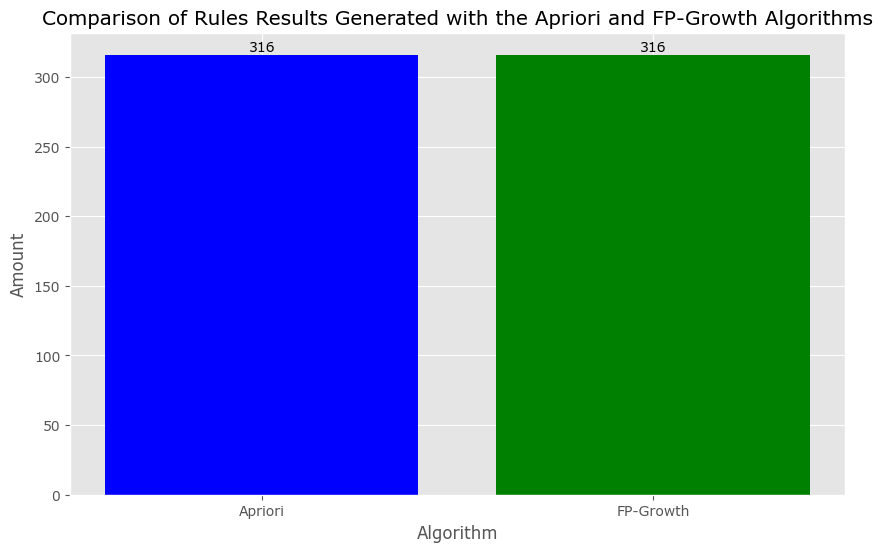

In [16]:
# Nama algoritma dan waktu komputasi
algorithms = ['Apriori', 'FP-Growth']
times = [len(rules_apriori), len(rules_fpgrowth)]

# Membuat bar plot
plt.figure(figsize=(10, 6))
plt.bar(algorithms, times, color=['blue', 'green'])

# Menambahkan judul dan label
plt.title('Comparison of Rules Results Generated with the Apriori and FP-Growth Algorithms')
plt.xlabel('Algorithm')
plt.ylabel('Amount')

# Menambahkan teks pada setiap bar
for i, amount in enumerate(times):
    plt.text(i, amount + 0.01, f'{amount}', ha='center', va='bottom')

# Menampilkan plot
plt.show()

In [17]:
# Display the computation times
print(f"Apriori algorithm time: {apriori_time:.4f} seconds")
print(f"FP-Growth algorithm time: {fpgrowth_time:.4f} seconds")

Apriori algorithm time: 70.4989 seconds
FP-Growth algorithm time: 3.8901 seconds


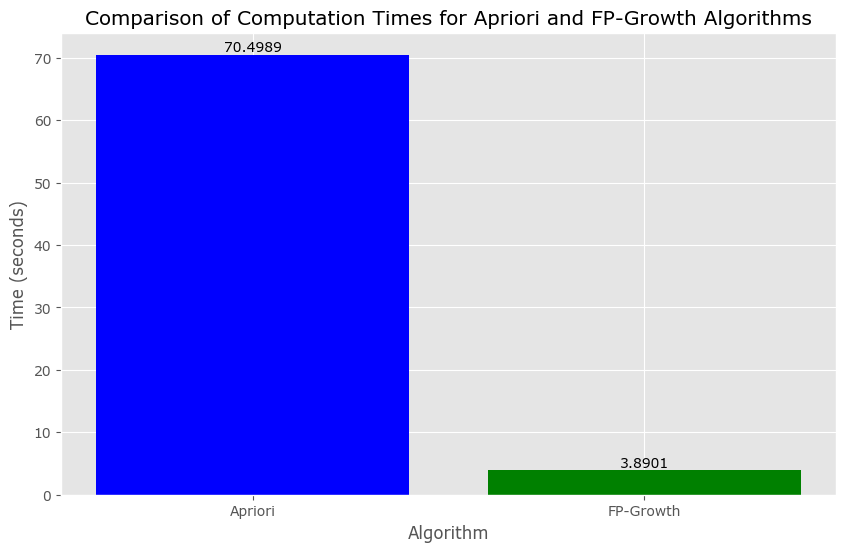

In [18]:
# Nama algoritma dan waktu komputasi
algorithms = ['Apriori', 'FP-Growth']
times = [apriori_time, fpgrowth_time]

# Membuat bar plot
plt.figure(figsize=(10, 6))
plt.bar(algorithms, times, color=['blue', 'green'])

# Menambahkan judul dan label
plt.title('Comparison of Computation Times for Apriori and FP-Growth Algorithms')
plt.xlabel('Algorithm')
plt.ylabel('Time (seconds)')

# Menambahkan teks pada setiap bar
for i, time in enumerate(times):
    plt.text(i, time + 0.01, f'{time:.4f}', ha='center', va='bottom')

# Menampilkan plot
plt.show()

Keterangan:
- FP-Growth lebih efisien dibandingkan dengan Apriori karena tidak perlu menghasilkan semua kandidat itemset dan tidak melakukan multiple pass database scanning yang berulang kali. 
- Struktur data FP-Tree membantu mengurangi jumlah komputasi dengan mengorganisir data transaksi secara lebih efisien dan memfasilitasi pemecahan masalah menjadi subset yang lebih kecil. 
- Oleh karena itu, FP-Growth dapat memproses data dengan jauh lebih cepat dibandingkan dengan Apriori, seperti yang terlihat dari perbandingan waktu eksekusi di atas.

In [19]:
# Function to run Apriori algorithm
def run_apriori():
    frequent_itemsets = apriori(basket_uk_encoded_filtered, min_support=0.02, use_colnames=True)
    rules_apriori = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
    rules_apriori = rules_apriori.sort_values("lift",ascending=False).reset_index(drop= True)
    return rules_apriori


# Function to run FP-Growth algorithm
def run_fpgrowth():
    frequent_itemsets = fpgrowth(basket_uk_encoded_filtered, min_support=0.02, use_colnames=True) 
    rules_fpgrowth = association_rules(frequent_itemsets, metric="lift", min_threshold=1) 
    rules_fpgrowth = association_rules(frequent_itemsets, metric="lift", min_threshold=1) 
    return rules_fpgrowth

# Mengukur penggunaan memori untuk Apriori
apriori_memory = memory_usage((run_apriori,), interval=0.1)
apriori_max_memory = max(apriori_memory)

# Mengukur penggunaan memori untuk FP-Growth
fpgrowth_memory = memory_usage((run_fpgrowth,), interval=0.1)
fpgrowth_max_memory = max(fpgrowth_memory)

# Menampilkan penggunaan memori
print(f"Apriori algorithm max memory usage: {apriori_max_memory:.2f} MiB")
print(f"FP-Growth algorithm max memory usage: {fpgrowth_max_memory:.2f} MiB")

c:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
c:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Apriori algorithm max memory usage: 8937.52 MiB
FP-Growth algorithm max memory usage: 646.61 MiB


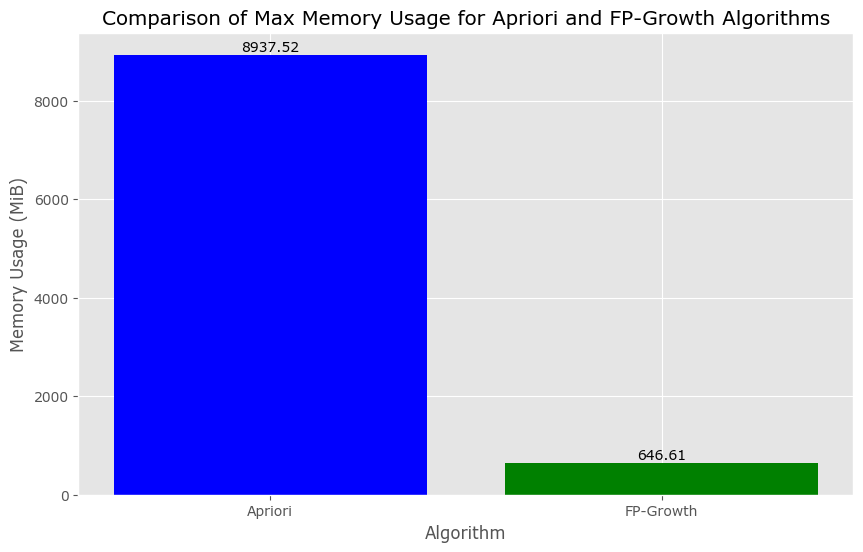

In [20]:
import matplotlib.pyplot as plt

# Nama algoritma dan penggunaan memori maksimum
algorithms = ['Apriori', 'FP-Growth']
memory_usage = [apriori_max_memory, fpgrowth_max_memory]

# Membuat bar plot
plt.figure(figsize=(10, 6))
plt.bar(algorithms, memory_usage, color=['blue', 'green'])

# Menambahkan judul dan label
plt.title('Comparison of Max Memory Usage for Apriori and FP-Growth Algorithms')
plt.xlabel('Algorithm')
plt.ylabel('Memory Usage (MiB)')

# Menambahkan teks pada setiap bar
for i, memory in enumerate(memory_usage):
    plt.text(i, memory + 0.5, f'{memory:.2f}', ha='center', va='bottom')

# Menampilkan plot
plt.show()

Keterangan:
- Algoritma Apriori menyimpan semua kemungkinan kombinasi item dalam setiap iterasi, bahkan juga yang jarang muncul. Hal ini menyebabkan penggunaan memori besar untuk menyimpannya, terutama pada dataset besar.
- FP-Growth menggunakan FP-Tree untuk mewakili dataset, mengidentifikasi itemset yang sering muncul tanpa perlu menyimpan seluruh dataset, mengurangi penggunaan memori secara signifikan.

## 5. Product Recommendation based on Association Rules

- Bagian rekomendasi produk dari proyek ini akan menggunakan Association Rules yang ditemukan di bagian Market Basket Analysis
- Rekomendasi produk pada dasarnya adalah salah satu keunggulan Market Basket Analysis di mana Anda dapat merekomendasikan kepada pelanggan produk yang berada dalam kumpulan item yang sama dengan produk pelanggan saat ini.

In [21]:
# List of all products
product_catalog = list(uk_retail['Description'].unique())
print(f'Ada {len(product_catalog)} produk unik di pasar UK.')

Ada 3893 produk unik di pasar UK.


In [22]:
def remove_from_list(y, item_to_search):
    # Membuat list baru untuk menyimpan item yang tidak ingin dihapus
    newlist = list()
    # Melakukan iterasi pada setiap item dalam list y
    for i in y:
        # Memeriksa apakah item tidak ada dalam item_to_search
        if i not in item_to_search:
            # Jika i tidak ada dalam item_to_search, maka tambahkan i ke dalam newlist
            newlist.append(i)
    return newlist

In [23]:
def search_list(item_to_search, list_to_search = rules_apriori['antecedents']):
    print(item_to_search)
    # Inisialisasi variabel untuk menyimpan nilai lift maksimum dan item yang direkomendasikan
    max_lift = 0
    item_to_recommend = ''
    # Melakukan iterasi melalui list_to_search
    for i, item in enumerate(list_to_search):
        # Memeriksa apakah item_to_search adalah subset dari item yang sedang diiterasi
        if set(list(item_to_search)).issubset(set(list(item))):
            # Jika subset ditemukan, periksa lift dan update nilai max_lift dan item_to_recommend jika diperlukan
            if rules_apriori['lift'][i] > max_lift:
                max_lift = rules_apriori['lift'][i]
                # Membuat salinan item antecedent untuk menghapus item_to_search
                y = list(rules_apriori['antecedents'][i])
                # Menghapus item_to_search dari item antecedent
                x = remove_from_list(y, item_to_search)
                # Menggabungkan consequent dan item yang tidak dihapus untuk membuat rekomendasi
                item_to_recommend = list(rules_apriori['consequents'][i]) + x
    
    # Jika tidak ada rekomendasi yang ditemukan, item_to_recommend tetap kosong
    if item_to_recommend == '':
        item_to_recommend = []
        # Mencetak pesan bahwa tidak ada rekomendasi yang tersedia
        print(f"Oops! Tidak ada rekomendasi produk yang tersedia saat ini!: {item_to_recommend}")
    else:
        # Jika ada rekomendasi yang ditemukan, mencetaknya
        print(f"Orang-orang juga membeli ini: {item_to_recommend}")
    # Return item yang dicari dan rekomendasi yang ditemukan
    return item_to_search, item_to_recommend


In [24]:
# Membuat dictionary kosong untuk menyimpan hasil pencarian
dict_to_store = {}

# Melakukan iterasi melalui indeks dari katalog produk
for i in range(len(product_catalog)):
    # Memanggil fungsi search_list untuk mencari rekomendasi untuk produk tertentu
    # Menyimpan hasilnya ke dalam variabel key dan value
    key, value = search_list([product_catalog[i]])
    # Menyimpan hasil pencarian ke dalam dictionary dengan key sebagai produk dan value sebagai rekomendasinya
    dict_to_store[key[0]] = value


['JUMBO BAG PINK POLKADOT']
Orang-orang juga membeli ini: ['JUMBO BAG WOODLAND ANIMALS', 'JUMBO BAG RED RETROSPOT']
['BLUE POLKADOT WRAP']
Oops! Tidak ada rekomendasi produk yang tersedia saat ini!: []
['RED RETROSPOT WRAP']
Oops! Tidak ada rekomendasi produk yang tersedia saat ini!: []
['RECYCLING BAG RETROSPOT']
Orang-orang juga membeli ini: ['DOTCOM POSTAGE']
['RED RETROSPOT SHOPPER BAG']
Oops! Tidak ada rekomendasi produk yang tersedia saat ini!: []
['JUMBO BAG RED RETROSPOT']
Orang-orang juga membeli ini: ['JUMBO BAG PINK POLKADOT', 'JUMBO BAG WOODLAND ANIMALS']
['RED RETROSPOT CHILDRENS UMBRELLA']
Oops! Tidak ada rekomendasi produk yang tersedia saat ini!: []
['JAM MAKING SET PRINTED']
Orang-orang juga membeli ini: ['JAM MAKING SET WITH JARS']
['RECIPE BOX RETROSPOT']
Oops! Tidak ada rekomendasi produk yang tersedia saat ini!: []
['CHILDRENS APRON APPLES DESIGN']
Oops! Tidak ada rekomendasi produk yang tersedia saat ini!: []
['PEG BAG APPLES DESIGN']
Oops! Tidak ada rekomendasi p

In [26]:
import json

json_file = json.dumps(dict_to_store)
# open file for writing, "w" 
f = open("item_sets.json","w")
# write json object to file
f.write(json_file)

# close file
f.close()

In [27]:
# Opening JSON file
with open('item_sets.json') as json_file:
    data = json.load(json_file)

In [28]:
for a in data['JUMBO BAG PINK POLKADOT']:
    print(a)

JUMBO BAG WOODLAND ANIMALS
JUMBO BAG RED RETROSPOT
